# Experimental regularization loss
*Use L(1 or 2) loss of the label loss derivative as a regularization loss.*  

## Setup

### Imports

In [25]:
import torch
from torch import nn
from torch import Tensor
import plotly.express as px
from torch.optim import Adam
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import (
    Compose,
    ToTensor,
    Normalize,
    RandomCrop,
)
from torchvision.utils import make_grid


from trainer import Trainer
from data_loaders import MyDataLoader

### Search for an accelerator

In [26]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

### Datasets, transforms and data loaders

In [27]:
! mkdir -p datasets

#### Transforms

In [28]:
CHANNELS_MEAN = (0.1307, )
CHANNELS_STD = (0.3081, )

training_transform = Compose([
    # RandomCrop(28, padding=6, padding_mode="constant"),
    ToTensor(),
    Normalize(CHANNELS_MEAN, CHANNELS_STD, inplace=True),
])

validation_transform = Compose([ToTensor(), Normalize(CHANNELS_MEAN, CHANNELS_STD)])

#### Datasets

In [29]:
training_dataset = MNIST(root="./datasets/mnist/", train=True, download=True, transform=training_transform)
validation_dataset = MNIST(root="./datasets/mnist/", train=False, transform=validation_transform)

#### Data loaders

In [30]:
BATCH_SIZE = 128

training_dl = MyDataLoader(training_dataset, BATCH_SIZE, shuffle=True, num_workers=3, device=device, pin_memory=True)
validation_dl = MyDataLoader(validation_dataset, BATCH_SIZE * 2, num_workers=3, device=device, pin_memory=True)

#### Dataset visualization

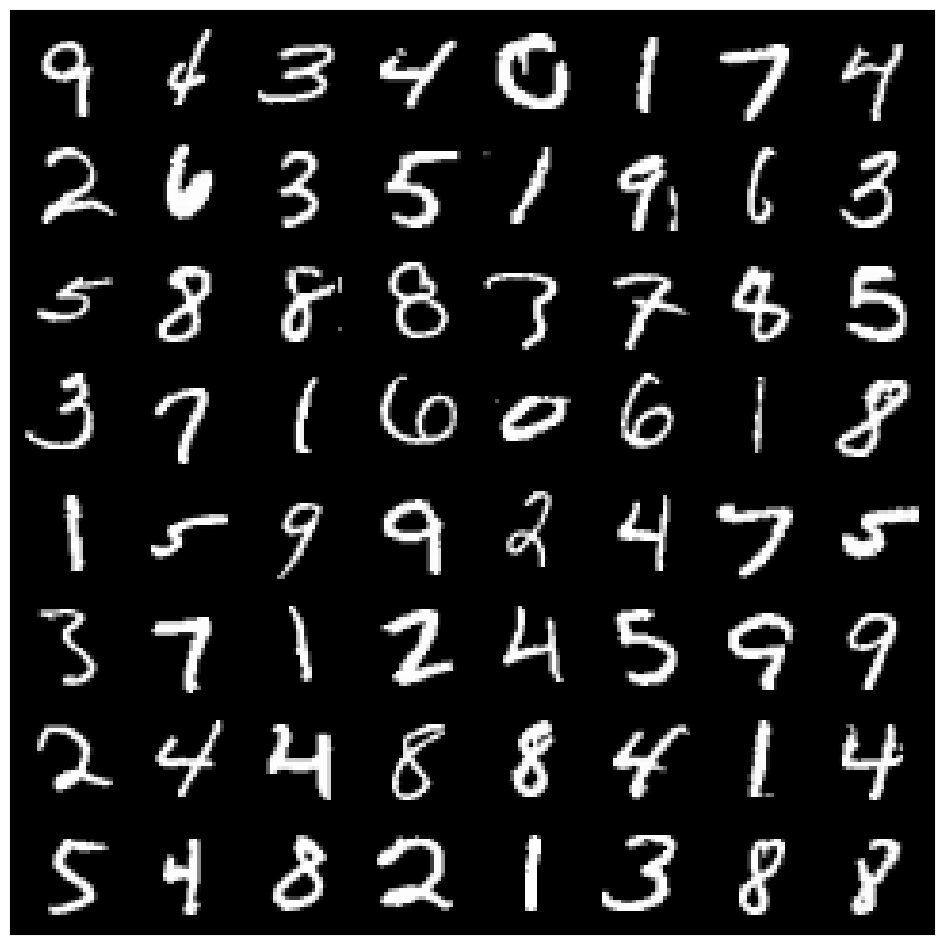

In [31]:
base_imgs, labels = next(iter(training_dl))
images, labels = base_imgs.cpu(), labels.cpu()
as_tensor = lambda stats: Tensor(stats).view(1, 1, 1, 1)
unormalize_imgs =  lambda imgs: imgs * as_tensor(CHANNELS_STD) + as_tensor(CHANNELS_MEAN)
images = unormalize_imgs(images)
fig, ax = plt.subplots(figsize=(12, 12))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))

## Model definition

In [35]:
# Model from pytorch example: https://github.com/pytorch/examples/blob/main/mnist/main.py
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

model = Net().cuda()

## Training

In [38]:
EPOCHS = 6
MAX_LR = 0.002
optimizer = Adam(model.parameters(), MAX_LR, weight_decay=1e-4)

trainer = Trainer(
    model,
    optimizer,
)

In [39]:
training_metrics = trainer.optimize_nn(
    epochs=EPOCHS,
    train_dl=training_dl,
    test_dl=validation_dl,
    plt_kwargs=dict(x="epoch", y=["train_loss", "train_accuracy", "test_loss", "test_accuracy", "lr"], height=600),
).set_index("epoch")

FigureWidget({
    'data': [{'hovertemplate': 'variable=train_loss<br>epoch=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': 'train_loss',
              'line': {'color': '#636efa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines+markers',
              'name': 'train_loss',
              'orientation': 'v',
              'showlegend': True,
              'type': 'scatter',
              'uid': '88dd584e-8cdd-457f-88df-d99f56f0ce63',
              'x': array([0]),
              'xaxis': 'x5',
              'y': array([0.51341424]),
              'yaxis': 'y5'},
             {'hovertemplate': 'variable=train_accuracy<br>epoch=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': 'train_accuracy',
              'line': {'color': '#EF553B', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines+markers',
              'name': 'train_accuracy',
              'orientation': 'v',
   

Exception in thread Thread-360 (_pin_memory_loop):
Traceback (most recent call last):
  File "/root/miniconda3/envs/learn-DL/lib/python3.11/threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "/root/miniconda3/envs/learn-DL/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/root/miniconda3/envs/learn-DL/lib/python3.11/threading.py", line 975, in run
    self._target(*self._args, **self._kwargs)
  File "/root/miniconda3/envs/learn-DL/lib/python3.11/site-packages/torch/utils/data/_utils/pin_memory.py", line 59, in _pin_memory_loop
    do_one_step()
  File "/root/miniconda3/envs/learn-DL/lib/python3.11/site-packages/torch/utils/data/_utils/pin_memory.py", line 35, in do_one_step
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/root/miniconda3/envs/learn-DL/lib/python3.11/multiprocessing/queues.py", line 122, in get
    return _ForkingPic

Caught KeyboardInterrupt exception, returning training metrics.


In [ ]:
training_metrics